# Traveling Salesman Problem

The traveling salesman problem is one of the most well-known NP-hard problems in theoretical computer science. It seeks and answer to the question "With a given list of cities and distances, what is the shortest route that visits each city exactly once, and returns to the starting city?". The objective function used here is the total distance of the route. In this instance, the cities are directly generated as coordinates. The route is encoded as a permutation of the indices of the cities. The objective function therefore could be thought of as follows:
$$
f(\mathbf{R}) = \sum_{i=2}^{n}\sqrt{(r_{i,1} - r_{i-1,1})^2 + (r_{i,2} - r_{i-1,2})^2} + \sqrt{(r_{n,1} - r_{1,1})^2 + (r_{n,2} - r_{1,2})^2}
$$
with $\mathbf{R}$ being the $n\times2$ matrix that contains the coordinates of the cities ordered by their incidence in the route.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
import random

## Generating The Problem

For the problem, I used a problem instance that has a known optimum to allow for objective comparison of performance. The instance is taken from the University of Heidelberg's [TSPLIB website](http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/).

In [2]:
with open("./berlin52.tsp") as file_obj:
    file_data = file_obj.readlines()
file_data

['NAME: berlin52\n',
 'TYPE: TSP\n',
 'COMMENT: 52 locations in Berlin (Groetschel)\n',
 'DIMENSION: 52\n',
 'EDGE_WEIGHT_TYPE: EUC_2D\n',
 'NODE_COORD_SECTION\n',
 '1 565.0 575.0\n',
 '2 25.0 185.0\n',
 '3 345.0 750.0\n',
 '4 945.0 685.0\n',
 '5 845.0 655.0\n',
 '6 880.0 660.0\n',
 '7 25.0 230.0\n',
 '8 525.0 1000.0\n',
 '9 580.0 1175.0\n',
 '10 650.0 1130.0\n',
 '11 1605.0 620.0\n',
 '12 1220.0 580.0\n',
 '13 1465.0 200.0\n',
 '14 1530.0 5.0\n',
 '15 845.0 680.0\n',
 '16 725.0 370.0\n',
 '17 145.0 665.0\n',
 '18 415.0 635.0\n',
 '19 510.0 875.0\n',
 '20 560.0 365.0\n',
 '21 300.0 465.0\n',
 '22 520.0 585.0\n',
 '23 480.0 415.0\n',
 '24 835.0 625.0\n',
 '25 975.0 580.0\n',
 '26 1215.0 245.0\n',
 '27 1320.0 315.0\n',
 '28 1250.0 400.0\n',
 '29 660.0 180.0\n',
 '30 410.0 250.0\n',
 '31 420.0 555.0\n',
 '32 575.0 665.0\n',
 '33 1150.0 1160.0\n',
 '34 700.0 580.0\n',
 '35 685.0 595.0\n',
 '36 685.0 610.0\n',
 '37 770.0 610.0\n',
 '38 795.0 645.0\n',
 '39 720.0 635.0\n',
 '40 760.0 650.0\n

In [3]:
cities_data = file_data[6:58]
example = cities_data[0]
example

'1 565.0 575.0\n'

In [4]:
example.split()

['1', '565.0', '575.0']

In [5]:
N_CITIES = 52
cities_x = [float(city.split()[1]) for city in cities_data]
cities_y = [float(city.split()[2]) for city in cities_data]
fast_cities_x = np.array(cities_x)
fast_cities_y = np.array(cities_y)

Plotting the cities.

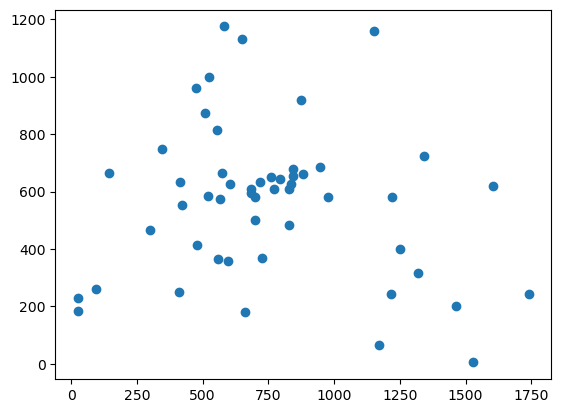

In [6]:
plt.scatter(cities_x, cities_y)

DEAP is used here to solve the problem, which allows for very fast prototyping.

The fitness and the individual is created here. Since we aim to minimize a particular function, it's called FitnessMin.
Single objective optimization is treated as a subset of multi-objective optimization in this step, so the "weights" that would be used to weigh the 
objectives against each other ends up just being -1.

In [7]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

The toolbox is created, and three tools are registered:
- "indices"
    - As a representation, a permutation of the indexes of the cities in the cities_X and cities_Y list will be used. This step registers each "gene" of the solution to be used later to produce individuals.
- "individual"
    - By following the blueprint set by the previous step iteratively, an individual is created.
- "population"
    - Creates the population by repeatedly creating individuals.

In [8]:
toolbox = base.Toolbox()
toolbox.register("indices", random.sample, range(N_CITIES), N_CITIES)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

This is the objective function in code.

In [9]:
def dist(individual):
    d = 0
    prev_x = cities_x[0]
    prev_y = cities_y[0]
    for i in individual[1:]:
        d += round(np.sqrt(np.square(cities_x[i] - prev_x) + np.square(cities_y[i] - prev_y)))
        prev_x, prev_y = cities_x[i], cities_y[i]
    d += round(np.sqrt(np.square(cities_x[individual[0]] - cities_x[individual[-1]]) + np.square(cities_y[individual[0]] - cities_y[individual[-1]])))
    return [d]

In [10]:
def fastdist(individual):
    ind_array = np.array(individual)
    dif_array = np.append(np.array([ind_array[i] for i in range(1, len(ind_array))]), ind_array[0])
    d = np.round(np.sqrt(np.square(fast_cities_x[dif_array] - fast_cities_x[ind_array]) + np.square(fast_cities_y[dif_array] - fast_cities_y[ind_array]))).sum()
    return [d]

In [29]:
def fasterdist(individual):
    ind_array = np.array(individual)
    mask = np.append(np.arange(1, len(ind_array)), 0)
    dif_array = ind_array[mask]
    d = np.round(np.sqrt(np.square(fast_cities_x[dif_array] - fast_cities_x[ind_array]) + np.square(fast_cities_y[dif_array] - fast_cities_y[ind_array]))).sum()
    return [d]

In [11]:
# sanity check
opt_solution = [1, 49, 32, 45, 19, 41, 8, 9, 10, 43, 33, 51, 11, 52, 14, 13, 47, 26, 27, 28, 12, 25, 4, 6, 15, 5, 24, 48, 38, 37, 40, 39, 36, 35, 34, 44, 46, 16, 29, 50, 20, 23, 30, 2, 7, 42, 21, 17, 3, 18, 31, 22]
opt_solution = [i - 1 for i in opt_solution]
dist(opt_solution)

[7542]

In [12]:
fastdist(opt_solution)

[7542.0]

In [32]:
fasterdist(opt_solution)

[7542.0]

In [235]:
%%timeit
dist(opt_solution)

90.1 µs ± 291 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [236]:
%%timeit
fastdist(opt_solution)

11.5 µs ± 45.7 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [237]:
%%timeit
fasterdist(opt_solution)

7.25 µs ± 74.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Our objective function works correctly, as 7542 is the optimal length.

Registering the evaluation function, and three operators: "mate", "mutate", "select".
- Mate: ordered crossover operator. Chosen over PMX as it offered better performance in my trials of this problem.
- Mutate: a mutation operator that shuffles the chromosome, produces valid offsprings because the chromosome is composed of indexes.
- Select: tournament selection operator. Chosen over roulette wheel selection as it might perform better as suggested in Razali et al. (2011).

In [231]:
toolbox.register("evaluate", fasterdist)
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=2)

Creating the population and initializing the algorithm. The algorithm in this instance is the simplest one, as presented by Baeck et al. (2018) in chapter 7. In the generational loop, recombination, mutation and evaluation is applied sequentially. When the predefined number of generations is reached, the alogrithm stops.

In [232]:
pop_eaSimple = toolbox.population(n=20_000)
pop_eaSimple, log = algorithms.eaSimple(pop_eaSimple, toolbox, cxpb=0.5, mutpb=0.2, ngen=1000, verbose=False)

Printing the best individual and its score.

In [239]:
best, best_score = pop_eaSimple[0], pop_eaSimple[0].fitness.values[0]

for ind in pop_eaSimple:
    if ind.fitness.values[0] < best_score:
        best = ind
        best_score = ind.fitness.values[0]     

print("Optimisation completed.")
print(f'f({best}) = {best_score}')

Optimisation completed.
f([43, 33, 34, 35, 48, 31, 0, 21, 17, 30, 22, 19, 49, 15, 28, 29, 1, 6, 41, 20, 16, 2, 44, 18, 40, 7, 8, 9, 42, 32, 50, 10, 51, 13, 12, 46, 25, 26, 27, 11, 24, 3, 5, 14, 4, 23, 47, 37, 39, 38, 36, 45]) = 7715.0


## Visualize the Best Solution

The best individual is translated from its index form to a list of node coordinates, then in turn plotted.

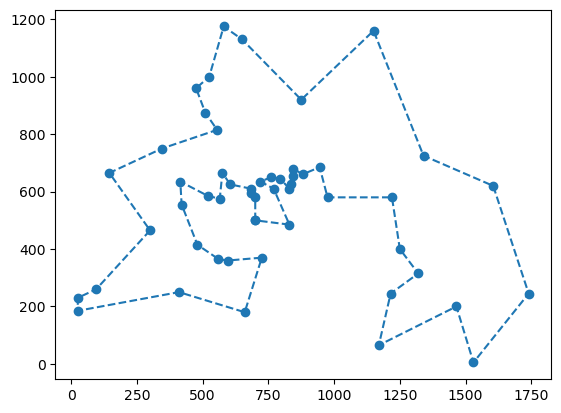

In [234]:
final_route_x = []
final_route_y = []
for i in best:
    final_route_x.append(cities_x[i])
    final_route_y.append(cities_y[i])

final_route_x.append(final_route_x[0])
final_route_y.append(final_route_y[0])

plt.plot(final_route_x, final_route_y, marker="o", linestyle="--")

References:\
Razali, N. M., & Geraghty, J. (2011). Genetic Algorithm Performance with Different Selection Strategies in Solving TSP.\
Baeck, T., Fogel, D. B., & Michalewicz, Z. (2018). Evolutionary Computation 1: Basic Algorithms and Operators. CRC Press.